In [1]:
import json
import numpy as np
import csv
import scipy.stats.distributions
from scipy.spatial.transform import Rotation
import os
from matplotlib import pyplot as plt
import random
import math
import cvxpy as cp
import csv

In [2]:
def dispersion_filtering(x, y, dispersion_threshold = 6, duraiton_threshold=0.2):
    start = 0
    window = []
    if len(x) == 0:
        return [], []
    fps = int(np.round(1/(x[1] - x[0])))
    duration_threshold_frames = np.ceil(duraiton_threshold * fps)
    
    def dispersion(arr):
        # input is a 2d array
        disp = np.max(arr[:, 0]) - np.min(arr[:, 0]) + np.max(arr[:, 1]) - np.min(arr[:, 1])
        return disp

    fixations = []
    fixations_intervals = []
    
    # while there are still points
    while int(start+duration_threshold_frames) < y.shape[0]:
        # initialize a window:
        window = list(range(int(start), int(start+duration_threshold_frames)))
        start = start + duration_threshold_frames
        disp = dispersion(y[window])
        # while the dispersion is less than the threshold
        while disp <= dispersion_threshold:
            if window[-1]+1 < y.shape[0]:
                window.append(window[-1]+1)
            start = start + 1
            if start >= y.shape[0]:
                break
            disp = dispersion(y[window])

        # if the current set of points never fit the duration criteria
        if len(window) <= duration_threshold_frames:
            start = start + 1
        # otherwise note it as fixations
        else:
            centroid = np.mean(y[window], axis=0)
            duration = (window[-1] - window[0]) / fps
            fixations.append([centroid[0], centroid[1], duration])
            fixations_intervals.append([window[0], window[-1]])
    fixations = np.array(fixations)
    return fixations, fixations_intervals
def get_head_angles(head_dir, target_dir, target_fixations_intervals, target_fixation_duration, persistant_target_angle = 0):
    # find the head fixations that are within the target fixations
    head_fixation_final_val = []
    head_fixations_closest_val = []
    head_fixations_extreme_val = [] # not being used
    head_fixations_value_held = [] # not being used 
    head_fixations_value_held_isValid = [] # not being used
    # find a few head fixations that are within the target fixations
    non_zero_fixation_angles = []
    non_zero_fixation_duration = []
    # find a few head fixations that are within the target fixations
    for i in range(0, len(target_fixations_intervals)):
        angle = target_dir[target_fixations_intervals[i][0]:target_fixations_intervals[i][1], 2].mean()
        if np.abs(angle - persistant_target_angle) > 0:
            non_zero_fixation_angles.append(angle) # this only record non-zero angles
            non_zero_fixation_duration.append(target_fixation_duration[i])
            target_interval = target_fixations_intervals[i]
            start = target_interval[0]
            end = target_interval[1]
            ################# find the head intervals that starts within the target interval, and use average as angle of the head #################
            # intersected = []
            # for j in range(0, len(head_fixations_intervals)):
            #     if head_fixations_intervals[j][0] >= start and head_fixations_intervals[j][0] <= end:
            #         intersected.append(j)
            # # the fixation interval closest to the target interval is selected
            # closest_angle = 10000000
            # closest_index = -100
            # if len(intersected) > 0:
            #     for j in intersected:
            #         head_fixation_value = head_dir[head_fixations_intervals[j][0]:head_fixations_intervals[j][1]][:, 2].mean()
            #         target_angle = target_dir[target_fixations_intervals[i][0]:target_fixations_intervals[i][1]][:, 2].mean()
            #         if np.abs(head_fixation_value - target_angle) < closest_angle:
            #             closest_angle = np.abs(head_fixation_value - target_angle)
            #             closest_index = j
            #     head_fixations_value_held.append(head_dir[head_fixations_intervals[closest_index][0]:head_fixations_intervals[closest_index][1]][:, 2].mean())
            #     head_fixations_value_held_isValid.append(True)
            # else:
            #     head_fixations_value_held.append(head_dir[target_fixations_intervals[i][0]:target_fixations_intervals[i][1]][:, 2].mean())
            #     head_fixations_value_held_isValid.append(False)
            
            ################# find the closest value within the target interval #################
            extreme_value_index = np.argmin(np.abs(head_dir[start:end][:, 2] - angle))
            head_fixations_closest_val.append(head_dir[start:end][:, 2][extreme_value_index])
            # if head_fixations_closest_val[-1] / target_dir[start:end][:, 2].mean() < 0:
            #     print("wrong sign")
            #     continue

            ################# find the extreme value within the target interval #################
            extreme_value_index = np.argmax(np.abs(head_dir[start:end][:, 2]))
            head_fixations_extreme_val.append(head_dir[start:end][:, 2][extreme_value_index])

            ################# find the final value within target interval #################
            head_fixation_final_val.append(head_dir[end][2])
            # plt.plot(head_dir[start:end][:, 0], head_dir[start:end][:, 2], label="head")
            # plt.plot(target_dir[start:end][:, 0], target_dir[start:end][:, 2], label="target")
            # plt.plot(head_dir[start:end][:, 0], np.ones(head_dir[start:end][:, 0].shape) * head_fixations_extreme_val[-1], label="head fixation (from extreme value method)")
            # plt.plot(head_dir[start:end][:, 0], np.ones(head_dir[start:end][:, 0].shape) * head_fixations_value_held[-1], label="head fixation (from value held method)")
            # plt.plot(head_dir[start:end][:, 0], np.ones(head_dir[start:end][:, 0].shape) * head_fixations_closest_val[-1], label="head fixation (from closest value method)")
            # plt.plot(head_dir[start:end][:, 0], np.ones(head_dir[start:end][:, 0].shape) * head_fixation_final_val[-1], label="head fixation (from final value method)")
          
            # plt.legend()
            # plt.show()
        else:
            head_fixations_closest_val.append(persistant_target_angle)
            head_fixations_extreme_val.append(persistant_target_angle)
            head_fixations_value_held.append(persistant_target_angle)
            head_fixations_value_held_isValid.append(False)
            non_zero_fixation_angles.append(persistant_target_angle)
            non_zero_fixation_duration.append(persistant_target_angle)
    
    head_fixations_closest_val = np.array(head_fixations_closest_val)
    head_fixations_extreme_val = np.array(head_fixations_extreme_val)
    head_fixations_value_held = np.array(head_fixations_value_held)
    head_fixations_value_held_isValid = np.array(head_fixations_value_held_isValid)
    head_fixation_final_val = np.array(head_fixation_final_val)
    non_zero_fixation_angles = np.array(non_zero_fixation_angles)
    non_zero_fixation_duration = np.array(non_zero_fixation_duration)
    
    return head_fixations_closest_val, non_zero_fixation_angles, non_zero_fixation_duration

        
class GaussianKernal:
    def __init__(self, loc, sigma, amplitude):
        self.sigma = sigma
        self.loc = loc
        self.amplitude = amplitude
        self.gaussina = scipy.stats.distributions.norm(loc, sigma)
    def cumulate(self, t_arr, x_arr):
        # t_arr is the time array
        # x_arr is the value array, in which we will cumulate a series of GaussianKernals
        x_arr += self.amplitude * self.gaussina.pdf(t_arr)
        return x_arr

def generate_smooth_distribution(fixation_angles):
    # generate a smooth distribution of the fixation ang
    kernal_list = []
    kernal_std = 3
    kernal_amplitude = 1
    for i in range(len(fixation_angles)):
        kernal_list.append(GaussianKernal(fixation_angles[i], kernal_std, kernal_amplitude))
    t_arr = np.linspace(-100, 100, 1000)
    x_arr = np.zeros(t_arr.shape)
    for kernal in kernal_list:
        x_arr = kernal.cumulate(t_arr, x_arr)
    x_arr = x_arr/np.sum(x_arr)
    return t_arr, x_arr, kernal_list
def generate_CHOR_distribution(head_angles, target_angles, target_angle_distribution):
    # find the closest angle in the target angle distribution for each head angle
    head_kernal_list = []
    for i in range(len(target_angles)):
        closest_target_angle_index = np.argmin(np.abs(target_angle_distribution[0] - target_angles[i]))
        # scaling the amplitude of each head angle by the corresponding target angle distribution
        head_kernal_list.append(GaussianKernal(head_angles[i], 3, 1 / target_angle_distribution[1][closest_target_angle_index]))
    t_arr = np.linspace(-100, 100, 1000)
    x_arr = np.zeros(t_arr.shape)
    for kernal in head_kernal_list:
        x_arr = kernal.cumulate(t_arr, x_arr)
    x_arr = x_arr/np.sum(x_arr)
    # find start and end range that contains 90% of the distribution
    cumulative_x_arr = np.cumsum(x_arr)
    start_index = np.argmin(np.abs(cumulative_x_arr - 0.05))
    end_index = np.argmin(np.abs(cumulative_x_arr - 0.95))
    start_angle = t_arr[start_index]
    end_angle = t_arr[end_index]

    return t_arr, x_arr, start_angle, end_angle
def get_CHOR(fixation_angles, head_fixation_angles, angle_to_ignore=0):
    is_not_zero = np.where(np.abs(fixation_angles-angle_to_ignore) <= 1E-3, False, True)
    target_angle_distribution = generate_smooth_distribution(fixation_angles[is_not_zero])
    head_angle_distribution = generate_CHOR_distribution(head_fixation_angles[is_not_zero], fixation_angles[is_not_zero], target_angle_distribution)
    CHOR_start, CHOR_end = head_angle_distribution[2], head_angle_distribution[3]
    return CHOR_start, CHOR_end, target_angle_distribution, head_angle_distribution

def align_target_and_results(collected_gaze, collected_duration, target_gaze, target_duration):
    deletion_index = -1
    for i in range(0, len(target_duration)):
        if np.abs(collected_gaze[i] - target_gaze[i]) > 1E-3:
            deletion_index = i
            break

    if deletion_index < 0:
        return target_gaze, target_duration
    else:
        new_target_gaze = np.concatenate([target_gaze[0:deletion_index], target_gaze[deletion_index+1:]])
        new_target_duration = np.concatenate([target_duration[0:deletion_index], target_duration[deletion_index+1:]])
        return new_target_gaze, new_target_duration



## Load Data

In [18]:
input_dirs = ["/Users/evanpan/Desktop/Experiment_related_files/recordings/TEST_REPEATED_CONTINIOUS_DWELL_PILOT_YIMA_FUTURE_CONDITIONS/collectedData",
              "/Users/evanpan/Desktop/Experiment_related_files/recordings/TEST_REPEATED_CONTINIOUS_DWELL_PILOT_DADA_FUTURE_CONDITIONS/collectedData",
              "/Users/evanpan/Desktop/Experiment_related_files/recordings/TEST_REPEATED_CONTINIOUS_DWELL_PILOT_EVAN_FUTURE_CONDITIONS/collectedData"]
all_eye_data = []
all_head_data = []
all_target_data = []
all_target_input = []
for input_dir in input_dirs:
    dirs = os.listdir(input_dir)
    recording_file_names = ['tennis_condition_pilot']
    data_types = ["gaze_dir", "head_dir", "head_pos", "target_pos"]
    # get duration of each trial:
    total_length = 0

    for fileName in recording_file_names:
        data_type = "gaze_dir"
        fullPath = os.path.join(input_dir, data_type + "_" + fileName + ".csv")
        eye_data = np.genfromtxt(fullPath, delimiter=',', dtype=float)
        
        data_type = "head_dir"
        fullPath = os.path.join(input_dir, data_type + "_" + fileName + ".csv")
        head_data = np.genfromtxt(fullPath, delimiter=',', dtype=float)
        
        data_type = "target_pos"
        fullPath = os.path.join(input_dir, data_type + "_" + fileName + ".csv")
        target_data = np.genfromtxt(fullPath, delimiter=',', dtype=float)
        
        all_eye_data.append(eye_data)
        all_head_data.append(head_data)
        all_target_data.append(target_data)
        
        setupFileName = os.path.join(*[input_dir, fileName+".json"])
        target_input = json.load(open(setupFileName, "r"))
        all_target_input.append(target_input)

In [19]:
input_dirs = ["/Users/evanpan/Desktop/Experiment_related_files/recordings/TEST_REPEATED_CONTINIOUS_DWELL_PILOT_YIMA_FUTURE_CONDITIONS/collectedData",
              "/Users/evanpan/Desktop/Experiment_related_files/recordings/TEST_REPEATED_CONTINIOUS_DWELL_PILOT_DADA_FUTURE_CONDITIONS/collectedData",
              "/Users/evanpan/Desktop/Experiment_related_files/recordings/TEST_REPEATED_CONTINIOUS_DWELL_PILOT_EVAN_FUTURE_CONDITIONS/collectedData"]
all_eye_data_calibration = []
all_head_data_calibration = []
all_target_data_calibration = []
all_target_input_calibration = []
for input_dir in input_dirs:
    dirs = os.listdir(input_dir)
    recording_file_names = ['calibration']
    data_types = ["gaze_dir", "head_dir", "head_pos", "target_pos"]
    # get duration of each trial:
    total_length = 0
    
    for fileName in recording_file_names:
        data_type = "gaze_dir"
        fullPath = os.path.join(input_dir, data_type + "_" + fileName + ".csv")
        eye_data = np.genfromtxt(fullPath, delimiter=',', dtype=float)
        
        data_type = "head_dir"
        fullPath = os.path.join(input_dir, data_type + "_" + fileName + ".csv")
        head_data = np.genfromtxt(fullPath, delimiter=',', dtype=float)
        
        data_type = "target_pos"
        fullPath = os.path.join(input_dir, data_type + "_" + fileName + ".csv")
        target_data = np.genfromtxt(fullPath, delimiter=',', dtype=float)
        
        all_eye_data_calibration.append(eye_data)
        all_head_data_calibration.append(head_data)
        all_target_data_calibration.append(target_data)
        
        setupFileName = os.path.join(*[input_dir, fileName+".json"])
        target_input = json.load(open(setupFileName, "r"))
        all_target_input_calibration.append(target_input)

In [20]:
def align_target_and_results(collected_gaze, collected_duration, target_gaze, target_duration):
    deletion_index = -1
    for i in range(0, len(target_duration)):
        if np.abs(collected_gaze[i] - target_gaze[i]) > 1E-3:
            deletion_index = i
            break

    if deletion_index < 0:
        return target_gaze, target_duration
    else:
        new_target_gaze = np.concatenate([target_gaze[0:deletion_index], target_gaze[deletion_index+1:]])
        new_target_duration = np.concatenate([target_duration[0:deletion_index], target_duration[deletion_index+1:]])
        return new_target_gaze, new_target_duration

In [21]:
def get_angle_per_instance(head_dir, eye_dir, target_pos, target_input, three_target=False):
        # prevent the angle from going to 360
    head_dir[:, 1:] = np.where(head_dir[:, 1:] > 180, head_dir[:, 1:] - 360, head_dir[:, 1:]) 
    eye_dir[:, 1:] = np.where(eye_dir[:, 1:] > 180, eye_dir[:, 1:] - 360, eye_dir[:, 1:])     
    
    # get the target directions
    target_dir = np.zeros(target_pos.shape)
    target_dir[:, 0] = target_pos[:, 0]
    for i in range(target_pos.shape[0]):
        # get the object rotation from scipy
        vec = target_pos[i, 1:]
        vec = vec / np.linalg.norm(vec)
        rot_y = np.sign(vec[0]) * (90 - np.arctan(abs(vec[2])/abs(vec[0])) * 180 / np.pi)
        # print(rot_y, target_dir[i, 2])
        target_dir[i, 2] = -rot_y
    # plt.plot(target_dir[:, 2].tolist())
    # note the dispersion is originally for a 2D input array
    target_fixations, target_fixations_intervals = dispersion_filtering(target_dir[:, 0], target_dir[:, 1:], 0.5, duraiton_threshold=0.0001)
    # find the number of nans in target_dir
    target_fixations_angles = target_fixations[:, 1]
    target_fixation_duration = target_fixations[:, 2]
    # get the combined head and eye angles
    gaze_dir = eye_dir + head_dir
    gaze_fixations, gaze_fixations_intervals = dispersion_filtering(gaze_dir[:, 0], gaze_dir[:, 1:], 3, duraiton_threshold=0.2)
    gaze_fixations_angles = gaze_fixations[:, 1]
    gaze_fixation_duration = gaze_fixations[:, 2]


    # get the target durations from the experimental setup file
    target_present_duration = target_input["duration"]
    # valid_target_list = np.array(target_input["isTarget"])
    # valid_target_list = np.where(valid_target_list==1, True, False)
    target_present_duration = np.array(target_present_duration)
    # target_present_duration = target_present_duration[valid_target_list]
    target_fixation_angles = target_input["angle"]
    target_fixation_angles = np.array(target_fixation_angles)
    # target_fixation_angles = target_fixation_angles[valid_target_list]
    
    head_fixation_angles, fixation_angles, fixation_duration = get_head_angles(head_dir, target_dir, target_fixations_intervals, target_fixation_duration, persistant_target_angle=0)
    # remove all the zero angles of collected data
    fixation_angles = np.array(fixation_angles)
    fixation_duration = np.array(fixation_duration)
    head_fixation_angles = np.array(head_fixation_angles)
    target_fixation_angles, target_present_duration = align_target_and_results(fixation_angles, fixation_duration, target_fixation_angles, target_present_duration)
    
    if three_target:
        # make sure the structure nice
        added_index = []
        minus_index = []
        off_set = 0
        for i in range(0, int(len(target_fixation_angles)/3)):
            if target_fixation_angles[3*i+1+off_set] in set([20, -40]):
                continue
            else:
                if target_fixation_angles[np.minimum(3*i+off_set, len(target_fixation_angles)-1)] in set([20, -40]):
                    added_index.append(3*i)
                    off_set += 1
                elif target_fixation_angles[np.minimum(3*i+2+off_set, len(target_fixation_angles)-1)] in set([20, -40]):
                    minus_index.append(3*i+2)
            
        target_fixation_angles = np.insert(target_fixation_angles, added_index, 0, axis=0)
        target_present_duration = np.insert(target_present_duration, added_index, 1, axis=0)
        head_fixation_angles = np.insert(head_fixation_angles, added_index, 0, axis=0)
        fixation_angles = np.insert(fixation_angles, added_index, 0, axis=0)        
    return target_fixation_angles, target_fixation_duration, fixation_angles, head_fixation_angles, target_present_duration


In [22]:
def get_interval_per_instance(head_dir, eye_dir, target_pos, target_input, three_target=False):
    head_dir[:, 1:] = np.where(head_dir[:, 1:] > 180, head_dir[:, 1:] - 360, head_dir[:, 1:]) 
    eye_dir[:, 1:] = np.where(eye_dir[:, 1:] > 180, eye_dir[:, 1:] - 360, eye_dir[:, 1:])     
    
    # get the target directions
    target_dir = np.zeros(target_pos.shape)
    target_dir[:, 0] = target_pos[:, 0]
    for i in range(target_pos.shape[0]):
        # get the object rotation from scipy
        vec = target_pos[i, 1:]
        vec = vec / np.linalg.norm(vec)
        rot_y = np.sign(vec[0]) * (90 - np.arctan(abs(vec[2])/abs(vec[0])) * 180 / np.pi)
        # print(rot_y, target_dir[i, 2])
        target_dir[i, 2] = -rot_y

    # note the dispersion is originally for a 2D input array
    target_fixations, target_fixations_intervals = dispersion_filtering(target_dir[:, 0], target_dir[:, 1:], 0, 0.05)
    target_fixations_angles = target_fixations[:, 1]
    target_fixation_duration = target_fixations[:, 2]
    target_fixation_angles = target_input["angle"]
    target_fixation_angles = np.array(target_fixation_angles)
    target_present_duration = target_input["duration"]

    head_fixation_angles, fixation_angles, fixation_duration = get_head_angles(head_dir, target_dir, target_fixations_intervals, target_fixation_duration, persistant_target_angle=0)
    
    # remove all the zero angles of collected data
    fixation_angles = np.array(fixation_angles)
    fixation_duration = np.array(fixation_duration)
    head_fixation_angles = np.array(head_fixation_angles)
    
    
    target_fixation_angles, target_present_duration = align_target_and_results(fixation_angles, fixation_duration, target_fixation_angles, target_present_duration)


    if three_target:
        # make sure the structure is nice
        added_index = []
        minus_index = []
        off_set = 0
        for i in range(0, int(len(target_fixation_angles)/3)):
            if target_fixation_angles[3*i+1+off_set] in set([20, -40]):
                continue
            else:
                if target_fixation_angles[np.minimum(3*i+off_set, len(target_fixation_angles)-1)] in set([20, -40]):
                    added_index.append(3*i)
                    off_set += 1
                elif target_fixation_angles[np.minimum(3*i+2+off_set, len(target_fixation_angles)-1)] in set([20, -40]):
                    minus_index.append(3*i+2)
        for i in range(0, len(added_index)):
            list.insert(target_fixations_intervals, added_index[len(added_index)-1-i], [0, 0])
        return target_fixations_intervals
    else:
        return target_fixations_intervals

# target_fixation_intervals = get_interval_per_instance(all_head_data[0], all_eye_data[0], all_target_data[0], all_target_input[0], True)


## compare distribution

In [23]:
print(all_target_input.__len__())

3


/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_43622/3696801529.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  rot_y = np.sign(vec[0]) * (90 - np.arctan(abs(vec[2])/abs(vec[0])) * 180 / np.pi)
/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_43622/2212957145.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  rot_y = np.sign(vec[0]) * (90 - np.arctan(abs(vec[2])/abs(vec[0])) * 180 / np.pi)


[array([10.13427  , -5.4025   ,  3.748901 , -5.545    ,  2.982856 ,
       -5.1158   ,  0.7281427, -6.4277   ,  5.107361 ,  1.719409 ])]


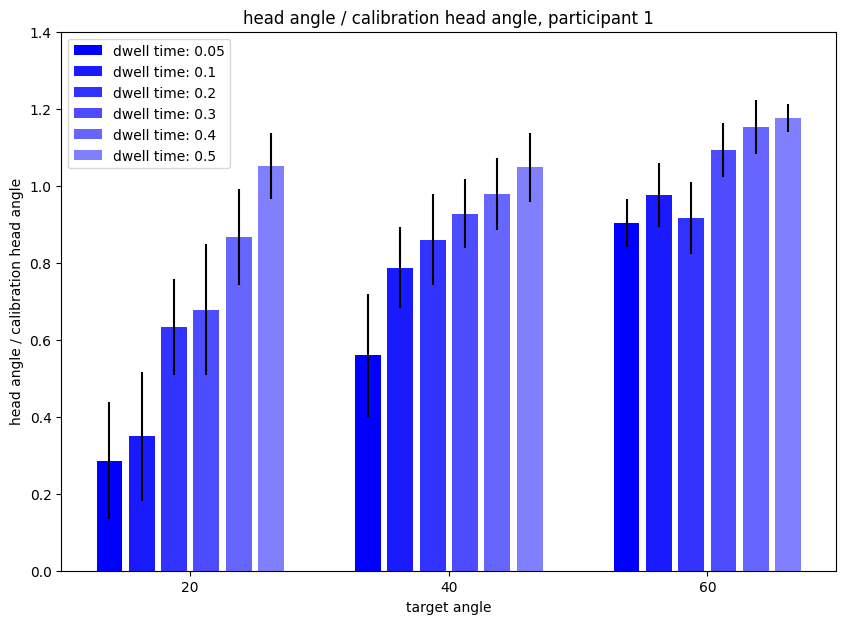

[array([ 6.127125, -2.2942  ,  1.979468, -2.8009  ,  8.926547, -4.7031  ,
       11.4465  , -2.0927  ,  7.436261, -5.5183  ])]


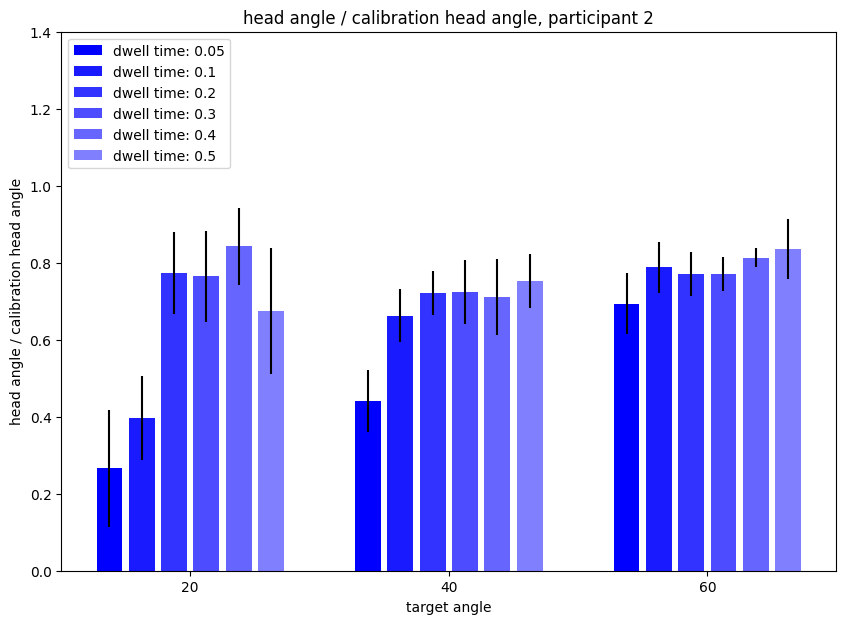

[array([ 5.166209 ,  3.970525 ,  2.681072 ,  2.111014 ,  2.861784 ,
        0.9378603,  2.528592 , -0.4063   ,  1.194894 , -2.1315   ])]


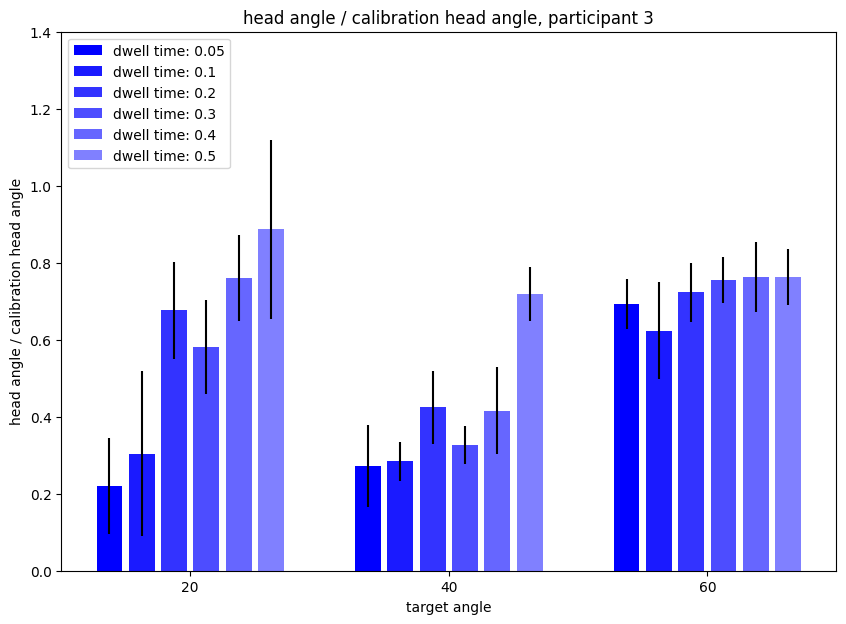

In [32]:
import matplotlib.colors as mcolors

plot_calibration = False
plot_trajectory = False

for cp in range(0, len(input_dirs)):
    head_dir = all_head_data[cp]
    eye_dir = all_eye_data[cp]
    target_pos = all_target_data[cp]
    target_input = all_target_input[cp]
    target_fixation_angles, target_fixation_duration, fixation_angles, head_fixation_angles, target_present_duration = get_angle_per_instance(head_dir, eye_dir, target_pos, target_input, False)
    target_intervals = get_interval_per_instance(head_dir, eye_dir, target_pos, target_input, False)
    # get indices of target fixation where the primary angle is 20 degrees
    calibration_head_dir = all_head_data_calibration[cp]
    calibration_eye_dir = all_eye_data_calibration[cp]
    calibration_target_pos = all_target_data_calibration[cp]
    calibration_target_input = all_target_input_calibration[cp]
    calibration_target_fixation_angles, calibration_target_fixation_duration, calibration_fixation_angles, calibration_head_fixation_angles, calibration_target_present_duration = get_angle_per_instance(calibration_head_dir, calibration_eye_dir, calibration_target_pos, calibration_target_input, False)

    # get a list of gaze angle with respect to head angles
    calibration_gaze_angles = []
    calibration_head_angles = []
    calibration_gaze_to_head = {}
    for i in range(0, len(calibration_fixation_angles)):
        if calibration_fixation_angles[i] != 0:
            calibration_gaze_angles.append(calibration_fixation_angles[i])
            calibration_head_angles.append(calibration_head_fixation_angles[i])
        calibration_gaze_to_head[int(np.round(calibration_fixation_angles[i]))] = calibration_head_fixation_angles[i]

    if plot_calibration:
        plt.plot([-90, 90], [-90, 90], label="full head contribution")
        plt.scatter(calibration_gaze_angles, calibration_head_angles, label="partcipant head contribution", color = "green")
        # plt.ylabel("head angle")
        # plt.xlabel("gaze target angle")
        plt.legend()
        plt.show()

    # get the interval during the tennis condition:
    dwell_times = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
    target_angle_list = [20, 40, 60]
    dwellXangle2head_angles_dict = {}
    dwellXangle2interval_dict = {}
    for i in range(0, len(target_fixation_angles) // 11):
        effective_target_indices = [i*11+1, (i+1) * 11]
        target_angles = target_fixation_angles[effective_target_indices[0]:effective_target_indices[1]]
        head_angles = head_fixation_angles[effective_target_indices[0]:effective_target_indices[1]]
        target_intervals_current = target_intervals[effective_target_indices[0]:effective_target_indices[1]]
        target_angles = np.array(target_angles)
        head_angles = np.array(head_angles)
        target_present_dwell = target_present_duration[effective_target_indices[0]:effective_target_indices[1]]
        target_present_dwell = np.array(target_present_dwell)
        # find the closest dwell time in dwell_times and angle in target_angle_list
        dwell = -1
        for dwell_time in dwell_times:
            if np.abs(target_present_dwell[0] - dwell_time) < 1E-3:
                closest = dwell_time
                break
        angle = -1
        for target_angle in target_angle_list:
            if np.abs(target_angles[0] - target_angle) < 1E-3:
                angle = target_angle
                break
        # store the head_angles in the dictionary
        try:
            dwellXangle2head_angles_dict[(closest, angle)].append(head_angles)
        except:
            dwellXangle2head_angles_dict[(closest, angle)] = [head_angles]
        if target_intervals != []:
            dwellXangle2interval_dict[(closest, angle)] = [target_intervals_current[0][0], target_intervals_current[-1][1]]
        else:
            dwellXangle2interval_dict[(closest, angle)] = [0, 0]
    
    # plot the trajectory of the head and gaze here
    plot_trajectory = False
    if plot_trajectory:
        for target_angle in target_angle_list:
            for dwell_time in dwell_times:
                # head trajectory
                times_arr = head_dir[dwellXangle2interval_dict[dwell_time, target_angle][0]:dwellXangle2interval_dict[dwell_time, target_angle][1], 0] - head_dir[dwellXangle2interval_dict[dwell_time, target_angle][0], 0]
                head_trajectory = head_dir[dwellXangle2interval_dict[dwell_time, target_angle][0]:dwellXangle2interval_dict[dwell_time, target_angle][1], 2]
                plt.plot(times_arr, head_trajectory, label="head trajectory")
                # gaze trajectory
                times_arr = eye_dir[dwellXangle2interval_dict[dwell_time, target_angle][0]:dwellXangle2interval_dict[dwell_time, target_angle][1], 0] - head_dir[dwellXangle2interval_dict[dwell_time, target_angle][0], 0]
                gaze_trajectory = eye_dir[dwellXangle2interval_dict[dwell_time, target_angle][0]:dwellXangle2interval_dict[dwell_time, target_angle][1], 2] + head_trajectory
                plt.plot(times_arr, gaze_trajectory, label="gaze trajectory")
                # plot a horizontal line to show the head contrution without the tennis conditions
                plt.plot([times_arr[0], times_arr[-1]], [calibration_gaze_to_head[target_angle], calibration_gaze_to_head[target_angle]], label="head contribution\nwithout tennis condition", color="green")
                plt.plot([times_arr[0], times_arr[-1]], [-calibration_gaze_to_head[target_angle], -calibration_gaze_to_head[target_angle]], color="green")
                plt.xlabel("time (s)")
                plt.ylabel("angle (deg)")
                plt.title("target angle: " + str(target_angle) + " dwell time: " + str(dwell_time))
                # set y limit 
                plt.ylim([-80, 80])
                plt.legend()
                plt.show()
    print(dwellXangle2head_angles_dict[(0.05, 20)])

    # plot the range for head angle as a function of dwell time, fixing the target angle at 20, 40 and 60

    # make plot bigger
    # make legend smaller
    plot_comparision = True
    if plot_comparision:
        plt.rcParams['legend.fontsize'] = 10
        plt.rcParams['figure.figsize'] = [10, 7]
        for i in range(len(target_angle_list)):
            for j in range(len(dwell_times)-1):
                target_angle = target_angle_list[i]
                dwell_time = dwell_times[j]
                head_angles = dwellXangle2head_angles_dict[(dwell_time, target_angle)]
                head_angles = np.abs(head_angles)
                # plt.scatter(np.ones(head_angles.shape) * dwell_time, head_angles, label="dwell time: " + str(dwell_time))    
                calibration_head_angle = calibration_gaze_to_head[target_angle]
                
                # calculate the mean and std of head angles relative to calibration head angle
                mean_head_vs_calibration = np.mean(head_angles/calibration_head_angle)
                std_head_vs_calibration = np.std(head_angles/calibration_head_angle)
                # plot each bar in a shade of green, from light to dark
                color = mcolors.CSS4_COLORS['blue']
                lighter_color = [min(c + j/10, 1.0) for c in mcolors.to_rgb(color)]
                plt.bar(i * len(dwell_times) + j + i*1, mean_head_vs_calibration, yerr=std_head_vs_calibration, label="dwell time: " + str(dwell_time), color=lighter_color)
                # label three different target angles on x axis
        plt.xticks([2.5, 7 + 3.5, 14 + 4.5], ["20", "40", "60"])
        # put a horizontal line to show the head contrution without the tennis conditions
                
        # plot the legend but remove any repeated labels
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys(), loc='upper left')
        plt.xlabel("target angle")
        plt.title("head angle / head angle, participant " + str(cp+1))
        plt.ylim([0, 1.4])
        plt.ylabel("head angle / calibration head angle")
        plt.show()
            


